In [1]:
#!pwd

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [3]:
# Definir rutas
base_dataset_path = '/Users/**/Documents/leWagon/Dataset Pneumonia/chest_xray/chest_xray'
train_dir = f'{base_dataset_path}/train'
validation_dir = f'{base_dataset_path}/val'
test_dir = f'{base_dataset_path}/test'

In [4]:
# Parámetros
img_height, img_width = 150, 150
batch_size = 32

In [5]:
# Preprocesamiento y aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8,1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
# Crear el modelo CNN
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
model.trainable = False
base_model = model
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(500, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')
model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
])

In [7]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [9]:
# Calcular steps_per_epoch y validation_steps
steps_per_epoch = max(1, train_generator.samples // batch_size)
validation_steps = max(1, validation_generator.samples // batch_size)

In [10]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/15


2024-06-26 00:49:24.738966: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


163/163 [==============================] - 148s 903ms/step - loss: 0.2905 - accuracy: 0.8878 - val_loss: 0.6763 - val_accuracy: 0.7500
Epoch 2/15
163/163 [==============================] - 151s 925ms/step - loss: 0.1948 - accuracy: 0.9212 - val_loss: 0.4202 - val_accuracy: 0.7500
Epoch 3/15
163/163 [==============================] - 152s 931ms/step - loss: 0.1736 - accuracy: 0.9333 - val_loss: 0.2783 - val_accuracy: 0.8750
Epoch 4/15
163/163 [==============================] - 152s 929ms/step - loss: 0.1620 - accuracy: 0.9348 - val_loss: 0.5406 - val_accuracy: 0.7500
Epoch 5/15
163/163 [==============================] - 151s 922ms/step - loss: 0.1549 - accuracy: 0.9390 - val_loss: 0.4122 - val_accuracy: 0.8125
Epoch 6/15
163/163 [==============================] - 150s 921ms/step - loss: 0.1399 - accuracy: 0.9461 - val_loss: 0.2990 - val_accuracy: 0.8750
Epoch 7/15
163/163 [==============================] - 150s 922ms/step - loss: 0.1535 - accuracy: 0.9375 - val_loss: 0.2488 - val_accura

In [11]:
# Evaluar el modelo
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_steps = max(1, test_generator.samples // batch_size)
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f'Test accuracy: {test_acc:.4f}')

Found 624 images belonging to 2 classes.
19/19 [==============================] - 17s 907ms/step - loss: 0.2221 - accuracy: 0.9145
Test accuracy: 0.9145


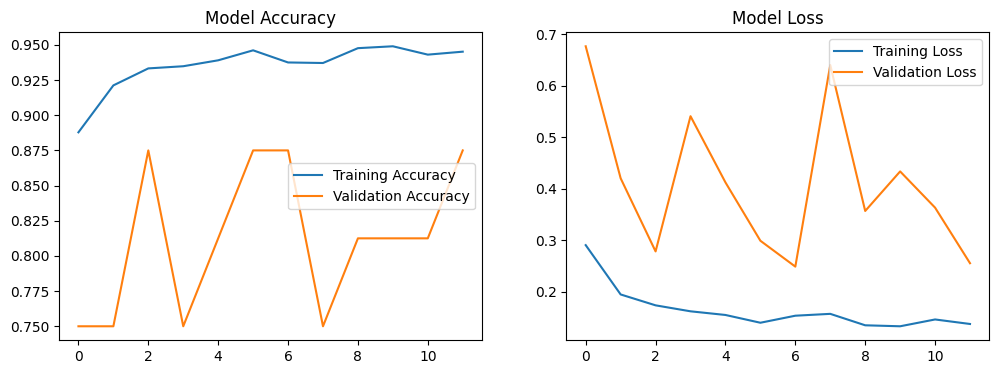

In [12]:
# Visualizar el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [13]:
# model.save('modelo_neumonia_vgg16.h5')

In [14]:
model.save_weights('modelo_neumonia_vgg16_weights.h5')